## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [5]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [6]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [7]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [8]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [11]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [12]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [15]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70142.55721218 67456.39127204 67318.3258893  70866.26065275]
Mean: 68945.8837565686


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [16]:
from sklearn.svm import SVR

C_vals = [1e5, 1e6, 1e7] ## YOUR VALUES FOR C ##
gamma_vals = [1e-2, 1e-1, 1e-0] ## YOUR VALUES FOR gamma ## 

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error',verbose=2,n_jobs=-1)
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] C=100000.0, gamma=0.1 ...........................................
[CV] C=100000.0, gamma=0.1 ...........................................
[CV] C=100000.0, gamma=0.1 ...........................................
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........................... C=100000.0, gamma=0.01, total=  11.9s
[CV] C=1000000.0,

[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  1.4min remaining:   41.5s


[CV] ........................... C=1000000.0, gamma=1.0, total= 3.7min
[CV] ........................... C=1000000.0, gamma=1.0, total= 3.9min
[CV] ........................... C=1000000.0, gamma=1.0, total= 4.3min
[CV] .......................... C=10000000.0, gamma=0.1, total= 6.4min
[CV] .......................... C=10000000.0, gamma=0.1, total= 7.7min
[CV] .......................... C=10000000.0, gamma=0.1, total= 8.6min
[CV] .......................... C=10000000.0, gamma=1.0, total=18.2min
[CV] .......................... C=10000000.0, gamma=1.0, total=19.2min
[CV] .......................... C=10000000.0, gamma=1.0, total=19.7min


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 20.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [100000.0, 1000000.0, 10000000.0], 'gamma': [0.01, 0.1, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [17]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 1000000.0, 'gamma': 0.1}
55421.599878040826


### Performance on Test Set

In [18]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

54175.050977783714


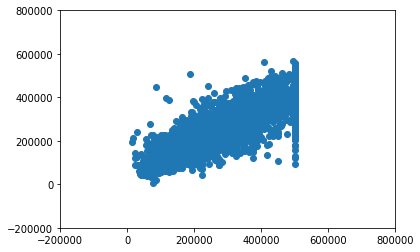

In [49]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [50]:
from sklearn.metrics import accuracy_score

In [51]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [52]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

#### Linear SVM for classification

In [53]:
from sklearn.svm import LinearSVC

In [54]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [55]:
y_pred = lin_clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.8385935769656699

In [56]:
# RMSE on training set
mse_tr_lin_clf = mean_squared_error(y_tr_b, y_pred)
rmse_tr_lin_clf = np.sqrt(mse_tr_lin_clf)
print(rmse_tr_lin_clf)

0.40175418234827376


### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

In [57]:
from sklearn.svm import SVC

In [58]:
# Initialize SVC Classifier
svc = SVC(random_state = 42)

In [59]:
# Fit on training set
svc.fit(X_tr, y_tr_b)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
# Accuracy score on the training set
y_pred_tr_svc = svc.predict(X_tr)
accuracy_score(y_tr_b, y_pred_tr_svc)

0.866140642303433

In [61]:
# RMSE on training set
mse_tr_svc = mean_squared_error(y_tr_b, y_pred_tr_svc)
rmse_tr_svc = np.sqrt(mse_tr_svc)
print(rmse_tr_svc)

0.36586795117441895


In [62]:
# Accuracy score on the test set
y_pred_te_svc = svc.predict(X_te)
accuracy_score(y_te_b, y_pred_te_svc)

0.8624031007751938

In [63]:
# RMSE on test set
mse_te_svc = mean_squared_error(y_te_b, y_pred_te_svc)
rmse_te_svc = np.sqrt(mse_te_svc)
print(rmse_te_svc)

0.37094056023142874


Since SVC's accuracy score on the training set is higher than that of LinearSVC, and the RMSE is lower, we can say that the SVC model with default hyperparameters is a better model than the LinearSVC model

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [65]:
param_distributions = {'C':uniform(1e2, 1e3), 'gamma':reciprocal(1e-3, 1e-1)}
rnd_search_svc = RandomizedSearchCV(SVC(), param_distributions, n_iter=10, cv=3, scoring='neg_mean_squared_error',verbose=2,n_jobs=-1)
rnd_search_svc.fit(X_tr, y_tr_b)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=1041.4413814405866, gamma=0.014189505114435185 ................
[CV] C=1041.4413814405866, gamma=0.014189505114435185 ................
[CV] C=1041.4413814405866, gamma=0.014189505114435185 ................
[CV] C=1062.0114990065294, gamma=0.02051712450447898 .................
[CV] C=1062.0114990065294, gamma=0.02051712450447898 .................
[CV] C=1062.0114990065294, gamma=0.02051712450447898 .................
[CV] C=1086.3692636718995, gamma=0.004630430834265572 ................
[CV] C=1086.3692636718995, gamma=0.004630430834265572 ................
[CV] C=1086.3692636718995, gamma=0.004630430834265572 ................
[CV] C=789.6670900788934, gamma=0.03956309463016349 ..................
[CV] C=789.6670900788934, gamma=0.03956309463016349 ..................
[CV] C=789.6670900788934, gamma=0.03956309463016349 ..................
[CV] . C=1086.3692636718995, gamma=0.004630430834265572, total=   8.6s
[CV] C=432.90634

[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   27.7s remaining:    8.4s


[CV] .. C=104.85475379144596, gamma=0.00185795627961527, total=   3.7s
[CV] .. C=104.85475379144596, gamma=0.00185795627961527, total=   3.3s
[CV] .. C=104.85475379144596, gamma=0.00185795627961527, total=   3.7s
[CV] ... C=659.7603230538487, gamma=0.06908125314129226, total=  12.8s
[CV] ... C=659.7603230538487, gamma=0.06908125314129226, total=  13.4s
[CV] ... C=659.7603230538487, gamma=0.06908125314129226, total=  13.3s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.7s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21c02748>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21bee080>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [66]:
print(rnd_search_svc.best_params_)
print(np.sqrt(-rnd_search_svc.best_score_))

{'C': 1062.0114990065294, 'gamma': 0.02051712450447898}
0.3530636363886514


### Performance on Train & Test Set

In [67]:
final_model_svc = rnd_search_svc.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

In [68]:
# Turn on probability calculation
final_model_svc.probability = True

In [69]:
# Refit model
final_model_svc.fit(X_tr, y_tr_b)

SVC(C=1062.0114990065294, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.02051712450447898,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [70]:
# Predict the training set
y_predict_svc_tr = final_model_svc.predict(X_tr)
y_proba_svc_tr = final_model_svc.predict_proba(X_tr)

In [71]:
# Predict the test set
y_predict_svc_te = final_model_svc.predict(X_te)
y_proba_svc_te = final_model_svc.predict_proba(X_te)

In [72]:
# RMSE
print('RMSE - Training')
print(np.sqrt(mean_squared_error(y_tr_b, y_predict_svc_tr)))
print('RMSE - Test')
print(np.sqrt(mean_squared_error(y_te_b, y_predict_svc_te)))

RMSE - Training
0.3270095043677536
RMSE - Test
0.35126202886149915


### AUC-ROC Curve

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [74]:
# Plot ROC curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])

In [75]:
# ROC AUC scores
print('ROC AUC - Train')
print(roc_auc_score(y_tr_b, y_proba_svc_tr[:,1]))
print('ROC AUC - Test')
print(roc_auc_score(y_te_b, y_proba_svc_te[:,1]))

ROC AUC - Train
0.9593928192554554
ROC AUC - Test
0.9447453954496208


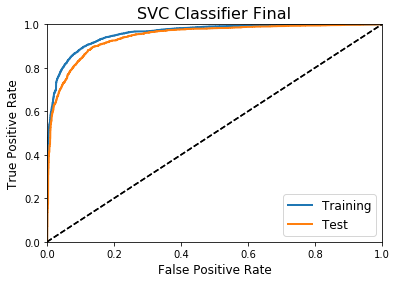

In [76]:
# ROC AUC curves
fpr_svc_tr, tpr_svc_tr, thresholds_svc_tr = roc_curve(y_tr_b, y_proba_svc_tr[:,1])
fpr_svc_te, tpr_svc_te, thresholds_svc_te = roc_curve(y_te_b, y_proba_svc_te[:,1])

plot_roc_curve(fpr_svc_tr, tpr_svc_tr, "Training")
plot_roc_curve(fpr_svc_te, tpr_svc_te, "Test")

plt.title('SVC Classifier Final', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()

The final SVC Classifier model has very good predictive power, and there's no over/under-fitting of the training set